### Figure 3: Results from perturbation experiment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cf_xarray
import cartopy.crs as ccrs
import cmocean as cm
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
from dask.distributed import Client
import matplotlib.path as mpath
import scipy as sp
import scipy.interpolate
import scipy.ndimage
import scipy.io
import scipy.stats
import pandas as pd
from pandas import DataFrame
import cartopy.feature as cft
from metpy.interpolate import cross_section
from pathlib import Path
import xgcm
from pyproj import Proj, transform
import pyproj
from datetime import datetime, timedelta
from xhistogram.xarray import histogram
import matplotlib.ticker as mticker
import intake

In [2]:
from dask.distributed import Client

client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40881,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45299,Total threads: 1
Dashboard: /proxy/37591/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:43489,


In [4]:
cat = intake.cat.access_nri
experiment = '01deg_jra55v140_iaf_cycle4' # the RYF90-91 experiment

exp_ds = cat[experiment]
exp_ds

,unique
filename,127845
path,131730
file_id,32
frequency,5
start_date,4324
end_date,4324
variable,335
variable_long_name,257
variable_standard_name,37
variable_cell_methods,6


In [5]:
grid_vars = ['xt_ocean','yt_ocean','st_edges_ocean','st_ocean']
coord_ds = exp_ds.search(
    variable=grid_vars, 
    file_id='ocean.1mon.nv:2.st_edges_ocean:76.st_ocean:75.xt_ocean:3600.yt_ocean:2700',
    frequency='1mon'
).to_dask(
    xarray_open_kwargs={
        'chunks' : "auto",
    }
)
xt_ocean = coord_ds['xt_ocean'].sel(xt_ocean=slice(-150,-50))
yt_ocean = coord_ds['yt_ocean'].sel(yt_ocean=slice(-80,-60))
st_ocean = coord_ds['st_ocean']

st_edges_ocean = coord_ds['st_edges_ocean']

In [8]:
aslat = slice(-75.5,-70)
aslon = slice(-120,-95)
latslice = slice(-76,-64.99) # make sure t and u cells have same lengths
lonslice = slice(-150,-70)
# Load data from perturbation experiments
pert_path = '/g/data/jk72/or6852/01deg_jra55_ryf_amundsen_perturbation_zonal200205/' # zonal
pert_path2 = '/g/data/jk72/or6852/01deg_jra55_ryf_amundsen_perturbation_both200205/' # both
cont_path = '/g/data/jk72/or6852/01deg_jra55_ryf_amundsen_perturbation_control/'

g=[]
g2 = []
q=[]
#q2 = []
for i in range(1000,1020):
    g.append(pert_path+'output'+str(i) + '/ocean/' + 'ocean_month.nc')
    g2.append(pert_path2+'output'+str(i) + '/ocean/' + 'ocean_month.nc')
    q.append(cont_path+'output'+str(i) + '/ocean/' + 'ocean_month.nc')

taux_pert = xr.open_mfdataset(g,combine='by_coords',chunks={'time': 1},decode_times = True)['tau_x'].sel(yu_ocean = slice(-77,-62)).sel(xu_ocean = slice(-150,-64))
taux_pert2 = xr.open_mfdataset(g2,combine='by_coords',chunks={'time': 1},decode_times = True)['tau_x'].sel(yu_ocean = slice(-77,-62)).sel(xu_ocean = slice(-150,-64))
taux_cont = xr.open_mfdataset(q,combine='by_coords',chunks={'time': 1},decode_times = True)['tau_x'].sel(yu_ocean = slice(-77,-62)).sel(xu_ocean = slice(-150,-64))

tauy_pert = xr.open_mfdataset(g,combine='by_coords',chunks={'time': 1},decode_times = True)['tau_y'].sel(yu_ocean = slice(-77,-62)).sel(xu_ocean = slice(-150,-64))
tauy_pert2 = xr.open_mfdataset(g2,combine='by_coords',chunks={'time': 1},decode_times = True)['tau_y'].sel(yu_ocean = slice(-77,-62)).sel(xu_ocean = slice(-150,-64))
tauy_cont = xr.open_mfdataset(q,combine='by_coords',chunks={'time': 1},decode_times = True)['tau_y'].sel(yu_ocean = slice(-77,-62)).sel(xu_ocean = slice(-150,-64))

temp_pert = xr.open_mfdataset(g,combine='by_coords',chunks={'time': 1},decode_times = True)['temp'].sel(yt_ocean = aslat).sel(xt_ocean = aslon).load() - 273.15
temp_pert2 = xr.open_mfdataset(g2,combine='by_coords',chunks={'time': 1},decode_times = True)['temp'].sel(yt_ocean = aslat).sel(xt_ocean = aslon).load() - 273.15
temp_cont = xr.open_mfdataset(q,combine='by_coords',chunks={'time': 1},decode_times = True)['temp'].sel(yt_ocean = aslat).sel(xt_ocean = aslon).load() - 273.15

salt_pert = xr.open_mfdataset(g,combine='by_coords',chunks={'time': 1},decode_times = True)['salt'].sel(yt_ocean = aslat).sel(xt_ocean = aslon).load()
salt_pert2 = xr.open_mfdataset(g2,combine='by_coords',chunks={'time': 1},decode_times = True)['salt'].sel(yt_ocean = aslat).sel(xt_ocean = aslon).load()
salt_cont = xr.open_mfdataset(q,combine='by_coords',chunks={'time': 1},decode_times = True)['salt'].sel(yt_ocean = aslat).sel(xt_ocean = aslon).load()


In [9]:
# Load grid variables: ht, area_t
ht = xr.open_dataset(pert_path+'output1000/ocean/ocean_grid.nc')['ht'].sel(yt_ocean = latslice).sel(xt_ocean = lonslice)
hu = xr.open_dataset(pert_path+'output1000/ocean/ocean_grid.nc')['hu'].sel(yu_ocean = latslice).sel(xu_ocean = lonslice)
area_t = xr.open_dataset(pert_path+'output1000/ocean/ocean_grid.nc')['area_t'].sel(yt_ocean = latslice).sel(xt_ocean = lonslice).fillna(0)
area_u = xr.open_dataset(pert_path+'output1000/ocean/ocean_grid.nc')['area_u'].sel(yu_ocean = latslice).sel(xu_ocean = lonslice).fillna(0)

In [10]:
# Calculate layer thickness
# Import edges of st_ocean and add lat/lon dimensions:
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean': ht.yt_ocean, 'xt_ocean': ht.xt_ocean}, axis=[1,2])

# Adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht, other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# Change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = temp_pert.st_ocean
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean': 'st_ocean'}))
thickness = thickness.fillna(0)

In [11]:
# Calculate layer thickness on u cells
st_edges_array = st_edges_ocean.expand_dims({'yu_ocean': hu.yu_ocean, 'xu_ocean': hu.xu_ocean}, axis=[1,2])

# Adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<hu, other=hu)
thickness_u = st_edges_with_partial.diff(dim='st_edges_ocean')

# Change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = temp_pert.st_ocean
thickness_u['st_edges_ocean'] = st_ocean.values
thickness_u = thickness_u.rename(({'st_edges_ocean': 'st_ocean'}))
thickness_u = thickness_u.fillna(0)

In [12]:
aslon = slice(-115,-95)
t_as = temp_pert.sel(xt_ocean = aslon).sel(yt_ocean = aslat).load()
t_asb = temp_pert2.sel(xt_ocean = aslon).sel(yt_ocean = aslat).load()
t_asc = temp_cont.sel(xt_ocean = aslon).sel(yt_ocean = aslat).load()

In [13]:
%%time
import gsw
import pygamma_n
pressure_as = gsw.p_from_z(-temp_pert.st_ocean,temp_pert.sel(yt_ocean = aslat).yt_ocean).expand_dims({'time':temp_pert.time,'xt_ocean':temp_pert.sel(xt_ocean = aslon).xt_ocean}).transpose('time','st_ocean','yt_ocean','xt_ocean')

SA_as = gsw.SA_from_SP(salt_pert.sel(xt_ocean = aslon).sel(yt_ocean = aslat), pressure_as, salt_pert.sel(xt_ocean = aslon).xt_ocean, salt_pert.sel(yt_ocean = aslat).yt_ocean)
PT_as = gsw.pt_from_CT(SA_as, t_as)
# for both
SA_asb = gsw.SA_from_SP(salt_pert2.sel(xt_ocean = aslon).sel(yt_ocean = aslat), pressure_as, salt_cont.sel(xt_ocean = aslon).xt_ocean, salt_cont.sel(yt_ocean = aslat).yt_ocean)
PT_asb = gsw.pt_from_CT(SA_asb, t_asb)

# for control
SA_asc = gsw.SA_from_SP(salt_cont.sel(xt_ocean = aslon).sel(yt_ocean = aslat), pressure_as, salt_cont.sel(xt_ocean = aslon).xt_ocean, salt_cont.sel(yt_ocean = aslat).yt_ocean)
PT_asc = gsw.pt_from_CT(SA_asc, t_asc)


# gamma
gamma_as, dg_lo, dg_hi = pygamma_n.gamma_n(salt_pert.sel(xt_ocean = aslon).sel(yt_ocean = aslat).stack(z=("time", "yt_ocean","xt_ocean")).T, 
                                      PT_as.stack(z=("time", "yt_ocean","xt_ocean")).T, 
                                      pressure_as.stack(z=("time", "yt_ocean","xt_ocean")).T,
                                (PT_as.xt_ocean.expand_dims({'time':PT_as.time,'yt_ocean':PT_as.yt_ocean}).
                                       stack(z=("time", "yt_ocean","xt_ocean"))),
                                      PT_as.yt_ocean.expand_dims({'time':PT_as.time,'xt_ocean':PT_as.xt_ocean}).stack(z=("time", "yt_ocean","xt_ocean")))
# gamma both
gamma_asb, dg_lo, dg_hi = pygamma_n.gamma_n(salt_pert2.sel(xt_ocean = aslon).sel(yt_ocean = aslat).stack(z=("time", "yt_ocean","xt_ocean")).T, 
                                      PT_asb.stack(z=("time", "yt_ocean","xt_ocean")).T, 
                                      pressure_as.stack(z=("time", "yt_ocean","xt_ocean")).T,
                                (PT_as.xt_ocean.expand_dims({'time':PT_as.time,'yt_ocean':PT_as.yt_ocean}).
                                       stack(z=("time", "yt_ocean","xt_ocean"))),
                                      PT_as.yt_ocean.expand_dims({'time':PT_as.time,'xt_ocean':PT_as.xt_ocean}).stack(z=("time", "yt_ocean","xt_ocean")))

# gamma control
gamma_asc, dg_lo, dg_hi = pygamma_n.gamma_n(salt_cont.sel(xt_ocean = aslon).sel(yt_ocean = aslat).stack(z=("time", "yt_ocean","xt_ocean")).T, 
                                      PT_asc.stack(z=("time", "yt_ocean","xt_ocean")).T, 
                                      pressure_as.stack(z=("time", "yt_ocean","xt_ocean")).T,
                                (PT_asc.xt_ocean.expand_dims({'time':PT_asc.time,'yt_ocean':PT_asc.yt_ocean}).
                                       stack(z=("time", "yt_ocean","xt_ocean"))),
                                      PT_asc.yt_ocean.expand_dims({'time':PT_asc.time,'xt_ocean':PT_asc.xt_ocean}).stack(z=("time", "yt_ocean","xt_ocean")))

# put into xarrays
gamma_xr_as = PT_as.stack(z=("time", "yt_ocean","xt_ocean")).T.copy()
gamma_xr_as.values = gamma_as
gamma_xr_as = gamma_xr_as.unstack('z')

gamma_xr_asb = PT_asb.stack(z=("time", "yt_ocean","xt_ocean")).T.copy()
gamma_xr_asb.values = gamma_asb
gamma_xr_asb = gamma_xr_asb.unstack('z')

gamma_xr_asc = PT_asc.stack(z=("time", "yt_ocean","xt_ocean")).T.copy()
gamma_xr_asc.values = gamma_asc
gamma_xr_asc = gamma_xr_asc.unstack('z')


CPU times: user 1h 25min 11s, sys: 1min 55s, total: 1h 27min 6s
Wall time: 1h 25min 34s


In [15]:
# Save gamma
f='/g/data/jk72/or6852/ensoant/pert_zonal_gamma.nc'
gamma_xr_as.to_dataset(name='gamma').to_netcdf(f) # save to file
f='/g/data/jk72/or6852/ensoant/pert_both_gamma.nc'
gamma_xr_asb.to_dataset(name='gamma').to_netcdf(f) # save to file
f='/g/data/jk72/or6852/ensoant/pert_control_gamma.nc'
gamma_xr_asc.to_dataset(name='gamma').to_netcdf(f) # save to file


In [16]:
# Load RYF winds + RYF perturbed winds:
ryf_u = xr.open_dataset('/g/data/jk72/or6852/amundsen_perturbation_forcing/pert.RYF.u_10.1990_1991.nc')['uas_10m'].sel(longitude = slice(205,305)).sel(latitude = slice(-77,-61)).mean('time')
ryf_uc = xr.open_dataset('/g/data/ik11/inputs/JRA-55/RYF/v1-3/RYF.u_10.1990_1991.nc')['uas_10m'].sel(longitude = slice(205,305)).sel(latitude = slice(-77,-61)).mean('time')

ryf_v = xr.open_dataset('/g/data/jk72/or6852/amundsen_perturbation_forcing/pert.RYF.v_10.1990_1991.nc')['vas_10m'].sel(longitude = slice(205,305)).sel(latitude = slice(-77,-61)).mean('time')
ryf_vc = xr.open_dataset('/g/data/ik11/inputs/JRA-55/RYF/v1-3/RYF.v_10.1990_1991.nc')['vas_10m'].sel(longitude = slice(205,305)).sel(latitude = slice(-77,-61)).mean('time')

ryf_v = ryf_v.assign_coords(longitude = ryf_v.longitude-360)
ryf_vc = ryf_vc.assign_coords(longitude = ryf_vc.longitude-360)

In [17]:
ht_large = xr.open_dataset(pert_path+'output1000/ocean/ocean_grid.nc')['ht'].sel(yt_ocean = slice(-77,-60)).sel(xt_ocean = slice(-160,-50))
# Define section
sla2 = xr.DataArray(np.linspace(-71.1,-75.1, 91))
slo2 = xr.DataArray(np.linspace(-114.5,-101.2,91))
t_sec_as2 = temp_pert.sel(st_ocean = slice(0,1200)).sel(xt_ocean = slo2, yt_ocean = sla2, method='nearest').load()
t_sec_asb2 = temp_pert2.sel(st_ocean = slice(0,1200)).sel(xt_ocean = slo2, yt_ocean = sla2, method='nearest').load()
t_sec_asc2 = temp_cont.sel(st_ocean = slice(0,1200)).sel(xt_ocean = slo2, yt_ocean = sla2, method='nearest').load()
gamma_sec_as2 = gamma_xr_as.sel(st_ocean = slice(0,1200)).sel(xt_ocean = slo2, yt_ocean = sla2, method='nearest').load()
gamma_sec_asb2 = gamma_xr_asb.sel(st_ocean = slice(0,1200)).sel(xt_ocean = slo2, yt_ocean = sla2, method='nearest').load()
gamma_sec_asc2 = gamma_xr_asc.sel(st_ocean = slice(0,1200)).sel(xt_ocean = slo2, yt_ocean = sla2, method='nearest').load()

In [22]:
# Plot parametres: define projection and boundary path, landmask
xt2d = xt_ocean.expand_dims({'yt_ocean':yt_ocean})
yt2d = yt_ocean.expand_dims({'xt_ocean':xt_ocean})

def make_boundary_path(longitudes, latitudes):
    """
    Return a path around boundary to create a sector map, then cut it out given
    longitudes and latitudes.
    """
    boundary_path = np.array([longitudes[-1, :], latitudes[-1, :]])
    boundary_path = np.append(boundary_path, np.array([longitudes[::-1, -1], latitudes[::-1, -1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([longitudes[1, ::-1],  latitudes[1, ::-1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([longitudes[:, 1],     latitudes[:, 1]]), axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))

    return boundary_path

# Eastern Amundsen
midlon = -107.5
maxlon = -95
minlon = -120
minlat = -75.609
maxlat = -70.509
midlat = (minlat + maxlat)/2
lons = xt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
lats = yt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)}).T
boundary_path_pibl = make_boundary_path(lons, lats)
extent_pibl = [minlon,maxlon,minlat,maxlat]
projection_pibl = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)


# West Antarctica
midlon = -105
maxlon = -70
minlon = -140
minlat = -76
maxlat = -64
midlat = (minlat + maxlat)/2
lons = xt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
lats = yt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)}).T
boundary_path_wa = make_boundary_path(lons, lats)
extent_wa = [minlon,maxlon,minlat,maxlat]
projection_wa = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

In [20]:
# Define for plotting
land_u = xr.where(np.isnan(hu.rename('land')), 1, np.nan)
land = xr.where(np.isnan(ht.rename('land')), 1, np.nan)
land100 = xr.where(np.isnan(ht.where(ht>100).rename('land')), 1, np.nan)

Text(0.5, 0, '')

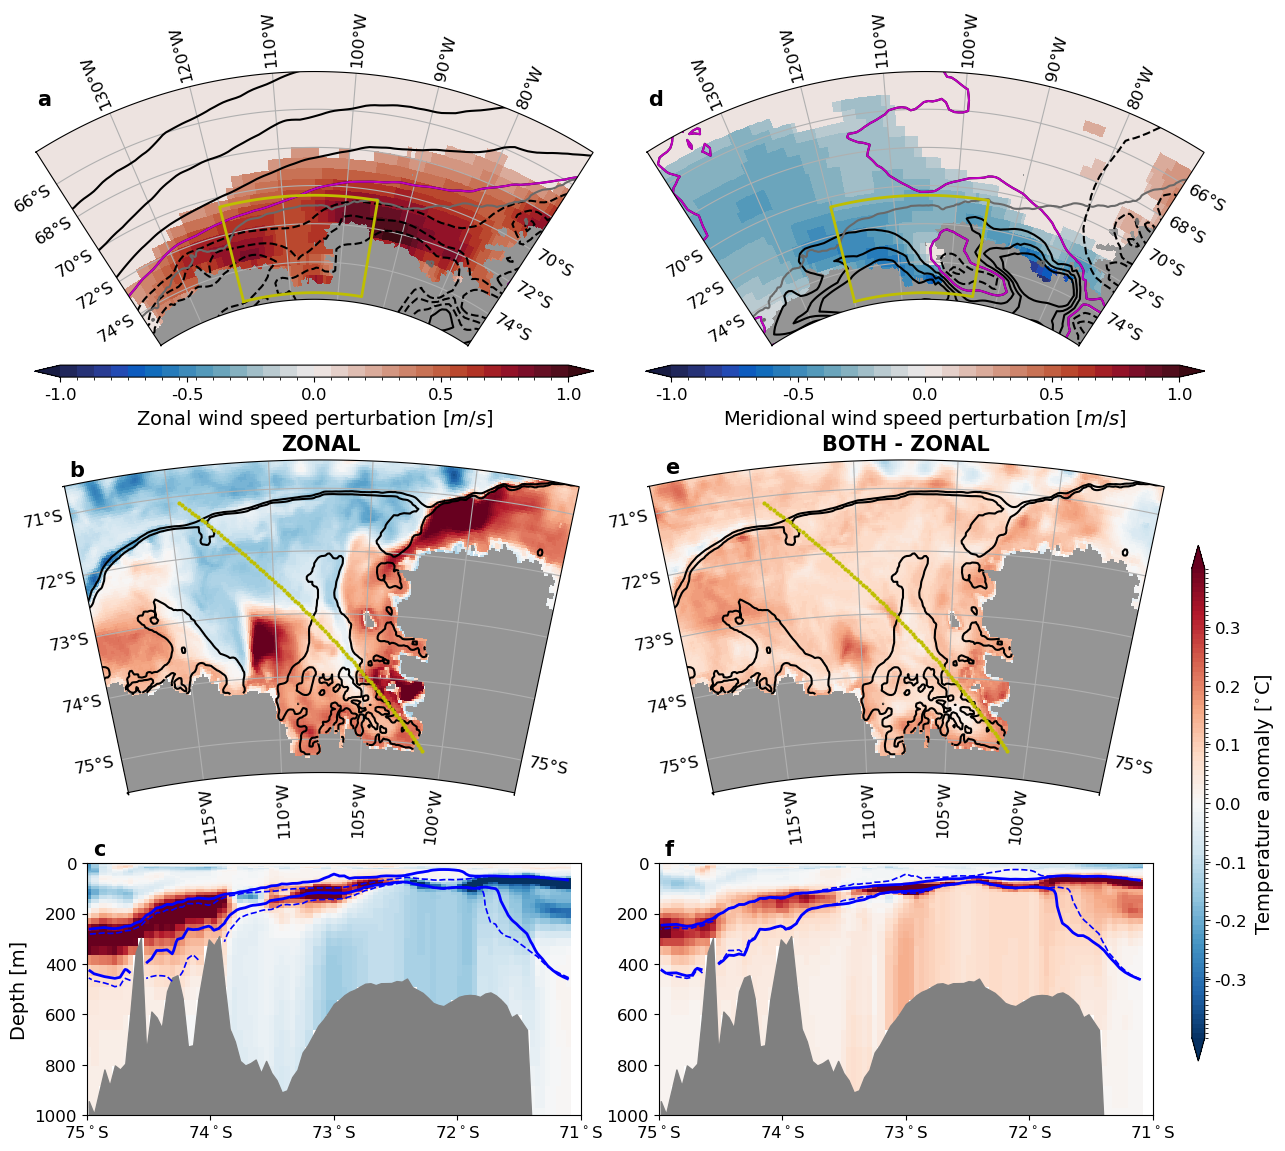

In [23]:
# Comparison Figure: Zonal only vs BOTH
boxlons = np.concatenate((np.arange(-120,-94,1),np.arange(-95,-121,-1),[-120]))
boxlats = np.concatenate((np.ones(26)*(-75.609),np.ones(26)*(-70.509),[-75.609]))
fig = plt.figure(figsize=(13,12))
# Subplot 1: Wind perturbation
ax1 = plt.axes([0.04,0.65,0.43,0.32],projection=projection_wa) # zonal wind perturbation
ax2 = plt.axes([0.06,0.29,0.4,0.32], projection = projection_pibl) # temp response map
ax3 = plt.axes([0.08,0.055,0.38,0.21]) # temp response section
ax4 = plt.axes([0.51,0.65,0.43,0.32],projection=projection_wa) # meridional wind perturbation
ax5 = plt.axes([0.51,0.29,0.4,0.32], projection = projection_pibl) # temp response map
ax6 = plt.axes([0.52,0.055,0.38,0.21]) # temp response section
axin1 = plt.axes([0.04,0.67,0.43,0.01]) # zonal wind colorbar
axin2 = plt.axes([0.51,0.67,0.43,0.01]) # meridional wind colorbar
axin3 = plt.axes([0.93,0.1,0.01,0.43]) # temp colorbar 



ax1.set_extent(extent_wa, crs=ccrs.PlateCarree())
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.ylocator = mticker.FixedLocator([-76, -74, -72,-70,-68,-66])
gl.bottom_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12, 'color': 'k'}
gl.ylabel_style = {'size': 12, 'color': 'k'}
ax1.set_boundary(boundary_path_wa, transform=ccrs.PlateCarree())

ryf_uc.plot.contour(ax=ax1,levels=np.arange(-4.5,5,1.5),colors='k',transform=ccrs.PlateCarree())
ryf_uc.sel(latitude = slice(-74,-65)).plot.contour(ax=ax1,levels=[0],colors='m',transform=ccrs.PlateCarree())
p1 = (ryf_u-ryf_uc).plot(ax=ax1,levels=np.linspace(-1,1,31),cmap=cm.cm.balance,extend='both',transform=ccrs.PlateCarree(),add_colorbar=False)

land.plot(ax=ax1,cmap='Greys',add_colorbar=False, transform=ccrs.PlateCarree())       
ht.sel(xt_ocean = slice(-130,-80)).sel(yt_ocean = slice(-73.2,-69)).plot.contour(ax=ax1,levels=[1000],linewidths=1.5,colors='dimgrey', transform=ccrs.PlateCarree())
ht.sel(xt_ocean = slice(-150,-130)).sel(yt_ocean = slice(-75,-72)).plot.contour(ax=ax1,levels=[1000],linewidths=1.5,colors='dimgrey', transform=ccrs.PlateCarree())
ht_large.sel(xt_ocean = slice(-80,-60)).sel(yt_ocean = slice(-70,-62)).plot.contour(ax=ax1,levels=[1000],linewidths=1.5,colors='dimgrey', transform=ccrs.PlateCarree())

cb=plt.colorbar(p1,cax=axin1,ticks=np.arange(-1,1.5,.5),orientation='horizontal',aspect = 50)
cb.set_label('Zonal wind speed perturbation [$m/s$]',fontsize=14)
cb.set_ticks(np.arange(-1,1.5,.5), labels=np.round(np.arange(-1,1.5,.5),1),fontsize=12)
ax1.text(-137,-62,'a',color='k',fontsize=15,fontweight='bold',transform=ccrs.PlateCarree())
ax1.plot(boxlons,boxlats,color='y',lw=2,transform=ccrs.PlateCarree())

# Subplot2: Temperature perturbation map
ax2.set_extent(extent_pibl, crs=ccrs.PlateCarree())
gl = ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12, 'color': 'k'}
gl.ylabel_style = {'size': 12, 'color': 'k'}
ax2.set_boundary(boundary_path_pibl, transform=ccrs.PlateCarree())    
p1 = (temp_pert-temp_cont).sel(st_ocean = slice(100,400)).weighted(thickness).mean('st_ocean')[24:,:,:].mean('time').plot(ax=ax2,
                    x='xt_ocean', y='yt_ocean', levels = np.linspace(-0.4,0.4,101), add_colorbar = False, cmap='RdBu_r', extend='both',
                    transform=ccrs.PlateCarree())
p3 = ht.plot.contour(ax=ax2,
                   x='xt_ocean', y='yt_ocean', levels=[600,1000], colors='k',linewidths=1.5, alphas=1,
                   transform=ccrs.PlateCarree())
land100.plot(ax=ax2,cmap='Greys',add_colorbar=False, transform=ccrs.PlateCarree())       
ax2.set_title('')
ax2.plot(slo2,sla2,color='y', ls='none', marker='o', markersize=2, transform=ccrs.PlateCarree())

# colorbars
cb=plt.colorbar(p1,cax=axin3,ticks=np.arange(-.3,.4,.1),orientation='vertical',aspect = 50)
cb.set_label('Temperature anomaly [$^{\circ}$C]',fontsize=14)
#cb.tick_params('y', labelsize=14)
cb.set_ticks(np.arange(-.3,.4,.1), labels=np.round(np.arange(-.3,.4,.1),1),fontsize=12)
ax2.text(-119.5,-70.4,'b',color='k',fontsize=15,fontweight='bold',transform=ccrs.PlateCarree())
ax2.text(-107.5,-70.4,'ZONAL',horizontalalignment='center', color='k',fontsize=15,fontweight = 'bold',transform=ccrs.PlateCarree())

# Subplot 3: Temperature section
p1=(t_sec_as2-t_sec_asc2)[24:,:,:].mean('time').plot(ax=ax3,x='yt_ocean',y='st_ocean',levels=np.linspace(-.4,.4,101),add_colorbar=False, extend='both')
# Add density lines
(gamma_sec_as2)[:,24:,:].mean({'time'}).plot.contour(ax=ax3,x='yt_ocean',y='st_ocean',levels=[27.9,28.1],colors='b',linewidths=2)
(gamma_sec_asc2)[:,24:,:].mean({'time'}).plot.contour(ax=ax3,x='yt_ocean',y='st_ocean',levels=[27.9,28.1],colors='b',linestyles='--',linewidths=1.2)

ax3.fill_between(ht.sel(xt_ocean = slo2, yt_ocean = sla2, method='nearest').yt_ocean,1500,ht.sel(xt_ocean = slo2, yt_ocean = sla2, method='nearest'),color='grey')
ax3.invert_yaxis()
ax3.set_xlim([-75,-71.1])
ax3.set_ylim([1000,0])
ax3.set_ylabel('Depth [m]',fontsize=14)
ax3.tick_params('y', colors='k', labelsize=12)
ax3.tick_params('x', colors='k', labelsize=12)
ax3.text(-74.95,-30,'c',color='k',fontsize=15, fontweight='bold')
ax3.set_xticks([-75,-74,-73,-72,-71],['75$^\circ$S','74$^\circ$S','73$^\circ$S','72$^\circ$S','71$^\circ$S'])
ax3.set_xlabel('')

### Now the same for the BOTH perturbation experiment
# Subplot 1: Wind perturbation
ax4.set_extent(extent_wa, crs=ccrs.PlateCarree())
gl = ax4.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.ylocator = mticker.FixedLocator([-76, -74, -72,-70,-68,-66])
gl.bottom_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 12, 'color': 'k'}
gl.ylabel_style = {'size': 12, 'color': 'k'}
ax4.set_boundary(boundary_path_wa, transform=ccrs.PlateCarree())

ryf_vc.plot.contour(ax=ax4,levels=np.arange(-4.5,5,1.5),colors='k',transform=ccrs.PlateCarree())
ryf_vc.plot.contour(ax=ax4,levels=[0],colors='m',transform=ccrs.PlateCarree())
p1 = (ryf_v-ryf_vc).plot(ax=ax4,levels=np.linspace(-1,1,31),cmap=cm.cm.balance,transform=ccrs.PlateCarree(),add_colorbar=False,extend='both')

land.plot(ax=ax4,cmap='Greys',add_colorbar=False, transform=ccrs.PlateCarree())       
ht.sel(xt_ocean = slice(-130,-80)).sel(yt_ocean = slice(-73.2,-69)).plot.contour(ax=ax4,levels=[1000],linewidths=1.5,colors='dimgrey', transform=ccrs.PlateCarree())
ht.sel(xt_ocean = slice(-150,-130)).sel(yt_ocean = slice(-75,-72)).plot.contour(ax=ax4,levels=[1000],linewidths=1.5,colors='dimgrey', transform=ccrs.PlateCarree())
ht_large.sel(xt_ocean = slice(-80,-60)).sel(yt_ocean = slice(-70,-62)).plot.contour(ax=ax4,levels=[1000],linewidths=1.5,colors='dimgrey', transform=ccrs.PlateCarree())

ax4.text(-137,-62,'d',color='k',fontsize=15,fontweight='bold',transform=ccrs.PlateCarree())
ax4.plot(boxlons,boxlats,color='y',lw=2,transform=ccrs.PlateCarree())
cb=plt.colorbar(p1,cax=axin2,ticks=np.arange(-1,1.5,.5),orientation='horizontal',aspect = 50)
cb.set_label('Meridional wind speed perturbation [$m/s$]',fontsize=14)
cb.set_ticks(np.arange(-1,1.5,.5), labels=np.round(np.arange(-1,1.5,.5),1),fontsize=12)

# Subplot2: Temperature perturbation map
ax5.set_extent(extent_pibl, crs=ccrs.PlateCarree())
gl = ax5.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12, 'color': 'k'}
gl.ylabel_style = {'size': 12, 'color': 'k'}
ax5.set_boundary(boundary_path_pibl, transform=ccrs.PlateCarree())    
p1 = (temp_pert2-temp_pert).sel(st_ocean = slice(100,400)).weighted(thickness).mean('st_ocean')[24:,:,:].mean('time').plot(ax=ax5,
                    x='xt_ocean', y='yt_ocean', levels = np.linspace(-0.4,0.4,101), add_colorbar = False, cmap='RdBu_r', extend='both',
                    transform=ccrs.PlateCarree())
p3 = ht.plot.contour(ax=ax5,
                   x='xt_ocean', y='yt_ocean', levels=[600,1000], colors='k',linewidths=1.5, alphas=1,
                   transform=ccrs.PlateCarree())
land100.plot(ax=ax5,cmap='Greys',add_colorbar=False, transform=ccrs.PlateCarree())       
ax5.set_title('')
# indicate section
ax5.plot(slo2,sla2,color='y', ls='none', marker='o', markersize=2, transform=ccrs.PlateCarree())

ax5.text(-119,-70.4,'e',color='k',fontsize=15,fontweight='bold',transform=ccrs.PlateCarree())
ax5.text(-107.5,-70.4,'BOTH - ZONAL',horizontalalignment='center', color='k',fontsize=15,fontweight = 'bold',transform=ccrs.PlateCarree())

# Subplot 3: Temperature section
p1=(t_sec_asb2-t_sec_as2)[24:,:,:].mean('time').plot(ax=ax6,x='yt_ocean',y='st_ocean',levels=np.linspace(-.4,.4,101),add_colorbar=False, extend='both')
# Add density lines
(gamma_sec_asb2)[:,24:,:].mean({'time'}).plot.contour(ax=ax6,x='yt_ocean',y='st_ocean',levels=[27.9,28.1],colors='b',linewidths=2)
(gamma_sec_as2)[:,24:,:].mean({'time'}).plot.contour(ax=ax6,x='yt_ocean',y='st_ocean',levels=[27.9,28.1],colors='b',linestyles='--',linewidths=1.2)

ax6.fill_between(ht.sel(xt_ocean = slo2, yt_ocean = sla2, method='nearest').yt_ocean,1500,ht.sel(xt_ocean = slo2, yt_ocean = sla2, method='nearest'),color='grey')
ax6.invert_yaxis()
ax6.set_xlim([-75,-71.1])
ax6.set_ylim([1000,0])
ax6.set_xlabel('Latitude',fontsize=14)
ax6.set_ylabel('',fontsize=14)
ax6.tick_params('y', colors='k', labelsize=12)
ax6.tick_params('x', colors='k', labelsize=12)
ax6.text(-74.95,-30,'f',color='k',fontsize=15, fontweight='bold')
ax6.set_xticks([-75,-74,-73,-72,-71],['75$^\circ$S','74$^\circ$S','73$^\circ$S','72$^\circ$S','71$^\circ$S'])
ax6.set_xlabel('')

#plt.savefig('/home/581/or6852/plots/figures/fig_pert_v6.png',dpi=500)